**Problems in Supply Chain**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from networkx.algorithms.community import girvan_newman
from networkx.algorithms import centrality

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

# Load node files
nodes = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Nodes/Nodes.csv")
nodes_index = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Nodes/NodesIndex.csv")
node_types = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv")
plant_storage = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Nodes/Nodes Type (Plant & Storage).csv")


In [ ]:
# Load edge files
edges_plant = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Edges/Edges (Plant).csv")
edges_product_group = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Edges/Edges (Product Group).csv")
edges_product_subgroup = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Edges/Edges (Product Sub-Group).csv")
edges_storage = pd.read_csv("/content/drive/MyDrive/Homogenoeus/Edges/Edges (Storage Location).csv")

----------------------------------------------------------------

➡️Graph1: Production Plant ↔ Storage Graph

Goal: to Identify overburdened storage facilities because more products produced , backup storage, and logistics dependencies.

applied : degree centrality

{'POV002L09P': 1.0, 'SOS001L12P': 1.0, 'POP002L09P': 0.9487179487179487, 'POP001L12P': 1.0, 'POV001L24P': 1.0, 'SOS005L04P': 1.0, 'POP500M24P': 1.0, 'ATN01K24P': 1.0, 'ATN02K12P': 0.8461538461538461, 'MAR02K12P': 0.7435897435897436, 'MAR01K24P': 1.0, 'SE500G24P': 1.0, 'SOS500M24P': 1.0, 'SOS008L02P': 1.0, 'POV500M24P': 0.9487179487179487, 'AT5X5K': 1.0, 'SOS002L09P': 1.0, 'SE200G24P': 0.9487179487179487, 'POPF01L12P': 0.6923076923076923, 'ATWWP001K24P': 0.923076923076923, 'POP005L04P': 0.8717948717948718, 'SOS250M48P': 1.0, 'SOS003L04P': 1.0, 'POV005L04P': 0.9487179487179487, 'MAHS025K': 0.8461538461538461, 'SOP001L12P': 0.8461538461538461, 'MASR025K': 0.9487179487179487, 'POP015K': 0.717948717948718, 'SO0005L04P': 0.5897435897435898, 'SO0002L09P': 0.5897435897435898, 'SO0001L12P': 0.5897435897435898, 'SO0500M24P': 0.6153846153846154, 'ATWWP002K12P': 0.717948717948718, 'ATPPCH5X5K': 0.717948717948718, 'ATPA1K24P': 0.5897435897435898, 'MAPA1K24P': 0.6153846153846154, 'MAP1K25P': 0.58974

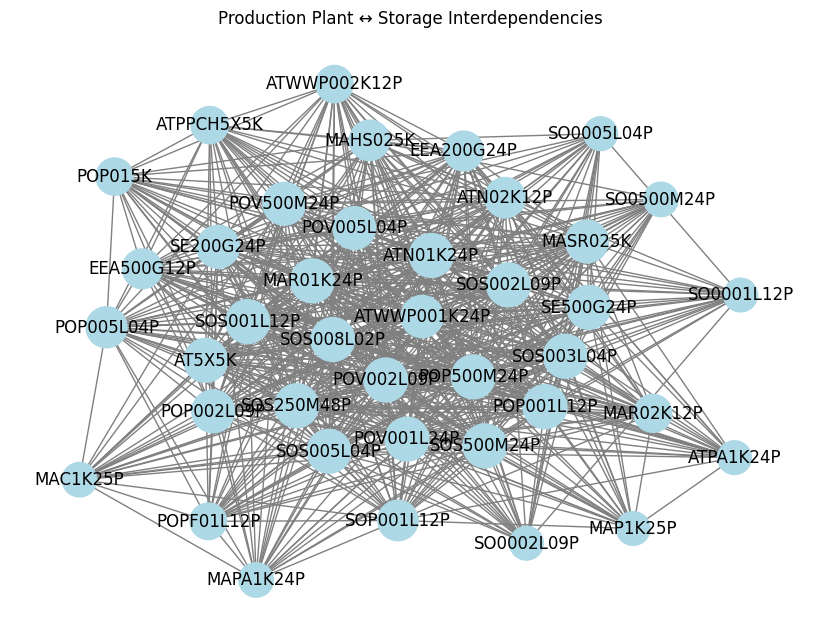

In [ ]:
G1 = nx.Graph()

# Add nodes (Plants & Storage)
for index, row in plant_storage.iterrows():
    G1.add_node(row["Node"], type="Plant" if pd.notna(row["Plant"]) else "Storage")

# Add edges (Plant ↔ Storage dependencies)
for index, row in edges_storage.iterrows():
    G1.add_edge(row["node1"], row["node2"])

# Calculate Degree Centrality (importance of storage locations)
centrality = nx.degree_centrality(G1)
print(centrality)
# Plot Graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, node_size=[v * 1000 for v in centrality.values()], node_color="lightblue", edge_color="gray")
plt.title("Production Plant ↔ Storage Interdependencies")
plt.show()


 -> Insights for Optimization :
(Critical Hubs)

The most connected nodes (degree = 1.0) should be monitored closely to avoid disruptions.

POV002L09P, SOS001L12P, POP001L12P, POV001L24P, SOS005L04P, POP500M24P, ATN01K24P, etc.

---------------------------------------------------------------------------

➡️ Graph 2: Product ↔ Storage Graph

*  Goal: Optimize product storage allocation, prevent overstocking, and ensure demand-supply balance.

solution : louvain







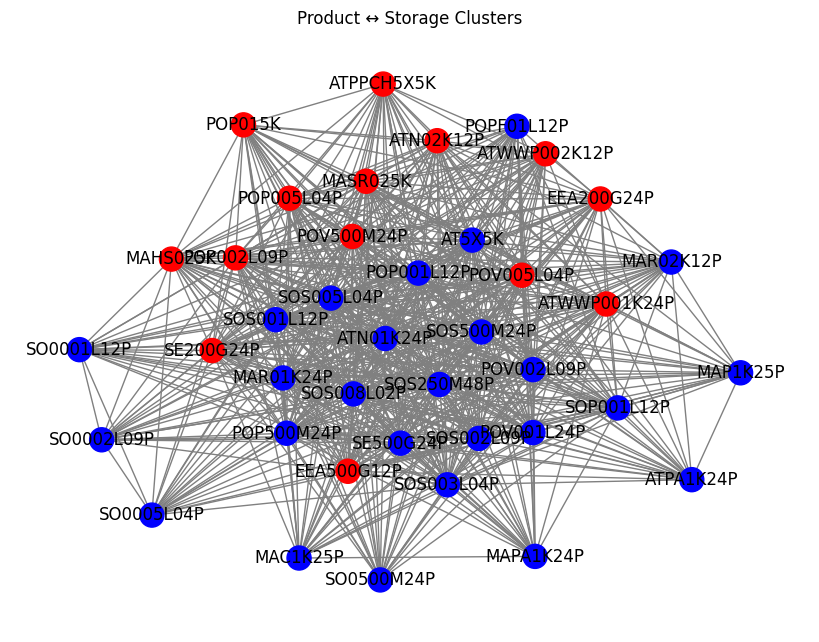

Graph Density: 0.1795
Average Clustering Coefficient: 0.0000


In [ ]:
import community.community_louvain as community_louvain
G2 = nx.Graph()

# Add nodes (Products & Storage)
for index, row in product_types.iterrows():
    G2.add_node(row["Node"], type="Product")

for index, row in plant_storage.iterrows():
    if pd.notna(row["Storage Location"]):
        G2.add_node(row["Node"], type="Storage")

# Add edges (Product ↔ Storage)
for index, row in edges_storage.iterrows():
    G2.add_edge(row["node1"], row["node2"])

# Apply Louvain Community Detection (Product-Storage clusters)
partition = community_louvain.best_partition(G2, random_state=42)  # Use community_louvain and best_partition
nx.set_node_attributes(G2, partition, 'community')

color_map = ["red", "blue", "green", "purple", "orange"]
community_colors = {node: color_map[partition.get(node, 0) % len(color_map)] for node in G2.nodes()}

# Plot Graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, node_color=[community_colors[node] for node in G2.nodes()], edge_color="gray")
plt.title("Product ↔ Storage Clusters")
plt.show()

density = nx.density(G)
avg_clustering = nx.average_clustering(G)

print(f"Graph Density: {density:.4f}")
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

🔍 Key Insights from the Graph:

1. Highly Connected Storage Locations **(Red Nodes)** are highly connected to multiple products.These represent central warehouses hubs that store a variety of products.

Insight: **A failure in these locations can disrupt the supply chain for multiple products.because no multiple loctaions**

2. Highly Connected Products **(Blue Nodes)** are linked to **multiple storage locations**.These products have multiple storage points, suggesting a redundant storage strategy.

Insight: Such products are less vulnerable to storage failures since they have alternative storage options.

3. Bottleneck Identification : If a highly connected storage location fails, the products dependent on it could face distribution issues.



-------------------------------------------------------------------------

➡️Graph 3: Product Group ↔ Subgroup Dependencies

🔎 Goal: Identifying which products are more and their requirement should be increased in manfacturing

solution : girvan-newman


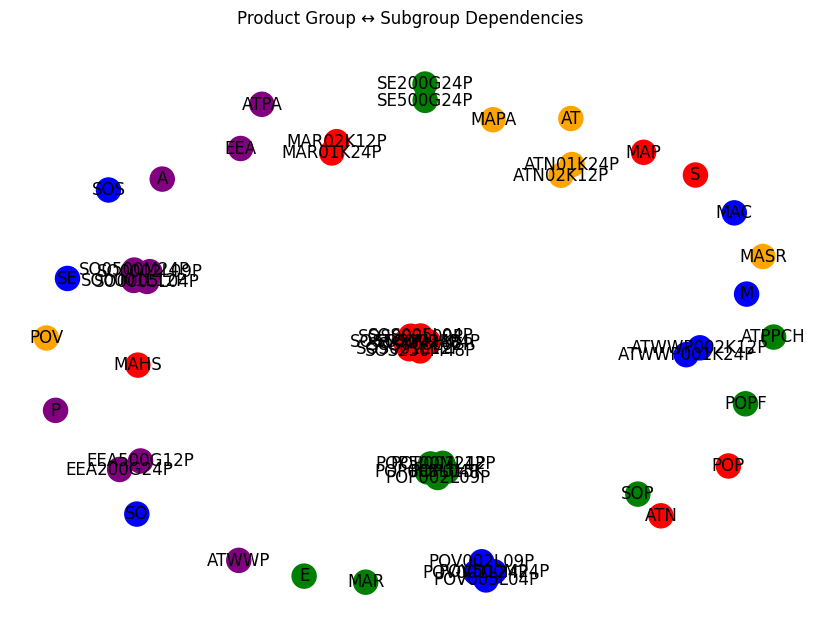

Average Clustering Coefficient: 0.3704


In [ ]:
G3 = nx.Graph()

# Add nodes (Product Groups & Subgroups)
for index, row in node_types.iterrows():
    G3.add_node(row["Group"], type="Group")
    G3.add_node(row["Sub-Group"], type="SubGroup")

# Add edges (Group ↔ Subgroup dependencies)
for index, row in edges_product_subgroup.iterrows():
    G3.add_edge(row["node1"], row["node2"])

# Apply Girvan-Newman Community Detection (Strong Dependencies)
communities = girvan_newman(G3)
top_level_communities = next(communities)
color_map = ["red", "blue", "green", "purple", "orange"]
community_colors = {node: color_map[i % len(color_map)] for i, com in enumerate(top_level_communities) for node in com}

# Plot Graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G3)
nx.draw(G3, pos, with_labels=True, node_color=[community_colors[node] for node in G3.nodes()], edge_color="gray")
plt.title("Product Group ↔ Subgroup Dependencies")
plt.show()

print(f"Average Clustering Coefficient: {nx.average_clustering(G3):.4f}")

Inference :

Central densely clustered nodes (Red, Blue, and Green groups) indicate highly interconnected subgroups.

Peripheral nodes (Scattered around the circle) have fewer dependencies.
Strategic Insights

Bottlenecks: Nodes/ Products in the center (e.g., SOS, POV, POP, etc.) could be critical points in the supply chain.

---------------------------------------------------------------------------

🟢 Graph 4: Plant ↔ Plant Interdependencies

*    Goal: Detect critical production facilities & optimize decentralization. and understand how each plant have Interdependencies

solution : to find interdependcies, applied betweeness centrality




Betweeness centrality :  {'AT5X5K': 0.008580746738641475, 'MASR025K': 0.0031938821412505623, 'SE500G24P': 0.0031826360773729192, 'POV002L09P': 0.003070154841409902, 'POP002L09P': 0.003070154841409902, 'POV001L24P': 0.003070154841409902, 'SOS008L02P': 0.003070154841409902, 'ATWWP001K24P': 0.0022042285200179934, 'POP500M24P': 0.0018494213838343393, 'POV005L04P': 0.0016967962312091865, 'MAR01K24P': 0.001675663517768781, 'POP001L12P': 0.0016322652456255697, 'SOS500M24P': 0.0016322652456255697, 'POP005L04P': 0.001584994702403609, 'SOS002L09P': 0.0013886005282766416, 'ATN02K12P': 0.0010571300044984254, 'POPF01L12P': 0.0009435983120193646, 'SOS003L04P': 0.0008463795913188625, 'SOS001L12P': 0.0008332591834616126, 'SE200G24P': 0.0008097165991902834, 'POV500M24P': 0.0006926833849910774, 'MAR02K12P': 0.0006635177687809267, 'ATN01K24P': 0.00022492127755285648, 'SOS250M48P': 0.00021194505000173014, 'SOP001L12P': 4.819741661846924e-05, 'SOS005L04P': 0.0, 'MAHS025K': 0.0, 'POP015K': 0.0, 'SO0005L04P'

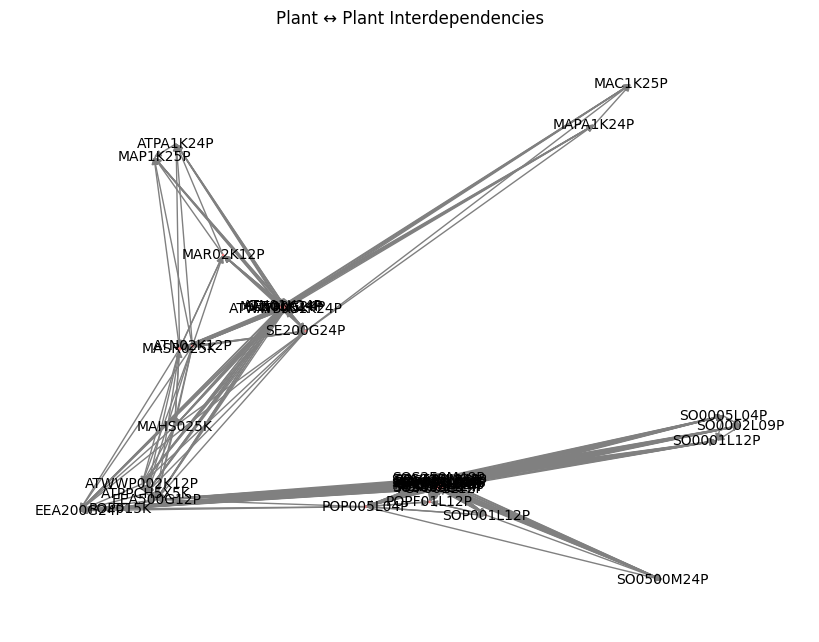

In [ ]:
G4 = nx.DiGraph()

# Add nodes (Plants)
for index, row in plant_storage.iterrows():
    if pd.notna(row["Plant"]):
        G4.add_node(row["Node"], type="Plant")

# Add edges (Plant dependencies)
for index, row in edges_plant.iterrows():
    G4.add_edge(row["node1"], row["node2"])

# Calculate Betweenness Centrality (Critical Facilities)
centrality = nx.betweenness_centrality(G4)
sorted_centrality = dict(sorted(centrality.items(), key=lambda item: item[1], reverse=True))

print("Betweeness centrality : ", sorted_centrality)

# Plot Graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G4)
nx.draw(G4, pos, with_labels=True, node_size=[v * 1000 for v in centrality.values()], node_color="lightcoral", edge_color="gray",font_size=10)
plt.title("Plant ↔ Plant Interdependencies")
plt.show()



->  **Heavily connected plants might need alternative supply routes to reduce risks.**

*   Some plants appear to have a large number of connections, indicating they share dependencies with multiple other plants.
*   These could represent multi-product plants or hubs that influence multiple supply chain segments.

*  A plant that connects otherwise unlinked clusters might act as a critical dependency.





--------------------------------------------------------------------------


 ➡️Graph 5: Supply Chain Efficiency (Shortest Paths & Critical Nodes)

*   Goal: Optimize logistics by finding critical paths & alternative routes  from product to storage location





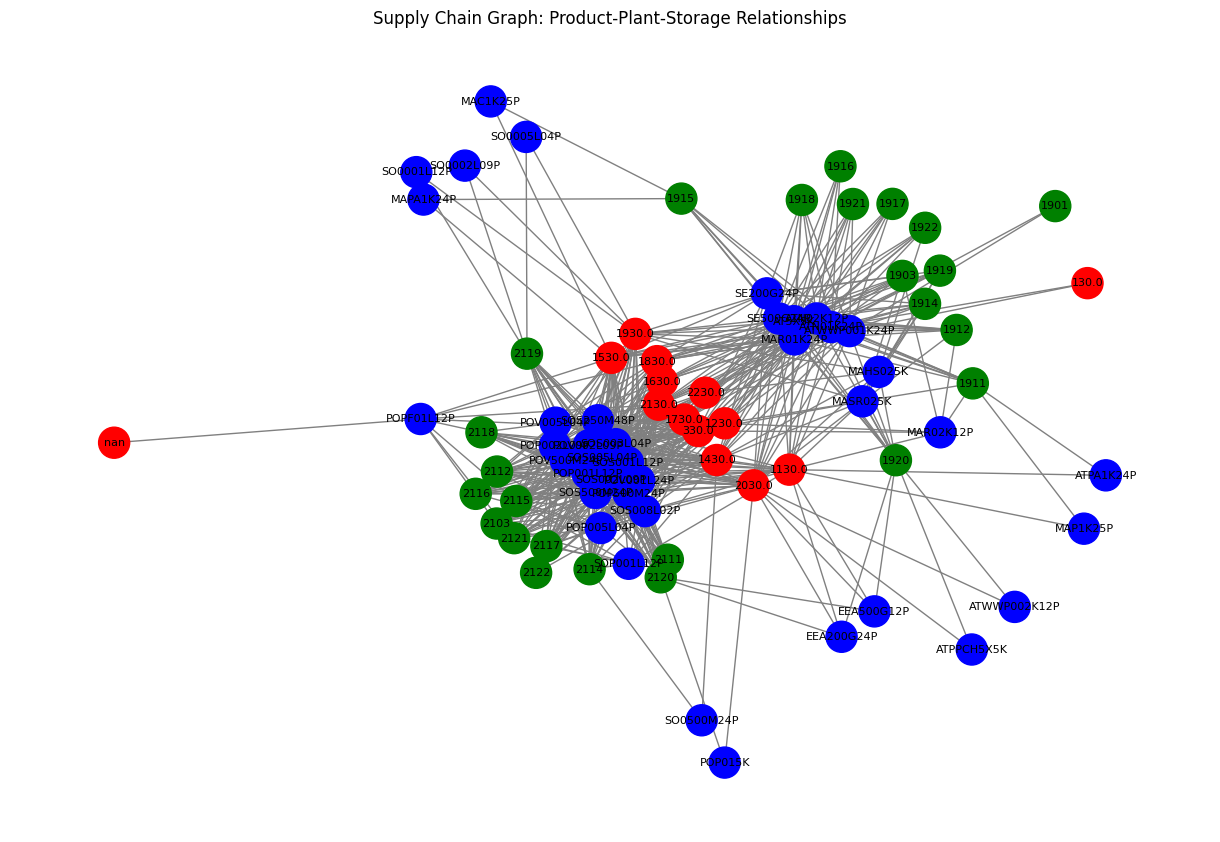

Nodes in Graph: ['POV002L09P', '2120', '2030.0', 'SOS001L12P', 'POP002L09P', 'POP001L12P', 'POV001L24P', 'SOS005L04P', 'POP500M24P', 'ATN01K24P', '1920', 'ATN02K12P', '1911', '1130.0', 'MAR02K12P', 'MAR01K24P', 'SE500G24P', '2111', 'SOS500M24P', 'SOS008L02P', 'POV500M24P', 'AT5X5K', '1921', '2130.0', '2121', 'SOS002L09P', '1917', '1730.0', '2117', 'SE200G24P', '2114', '1430.0', '2119', '1930.0', 'POPF01L12P', 'ATWWP001K24P', '1916', '1630.0', '2116', 'POP005L04P', 'SOS250M48P', '1918', '1830.0', '2118', 'SOS003L04P', '2112', '1230.0', 'POV005L04P', '1919', '1915', '1530.0', '2115', '1912', '2103', '330.0', 'MAHS025K', '1922', '2230.0', '2122', '1914', '1903', 'SOP001L12P', 'MASR025K', '1901', '130.0', 'nan', 'POP015K', 'SO0005L04P', 'SO0002L09P', 'SO0001L12P', 'SO0500M24P', 'ATWWP002K12P', 'ATPPCH5X5K', 'ATPA1K24P', 'MAPA1K24P', 'MAP1K25P', 'MAC1K25P', 'EEA500G12P', 'EEA200G24P']


In [ ]:

# Convert all relevant columns to string type
plant_storage["Plant"] = plant_storage["Plant"].astype(str)
plant_storage["Storage Location"] = plant_storage["Storage Location"].astype(str)
plant_storage["Node"] = plant_storage["Node"].astype(str)

# Create Graph
G1 = nx.Graph()

# Step 1: Add Nodes
for _, row in plant_storage.iterrows():
    node = row["Node"].strip()
    plant = row["Plant"].strip()
    storage = row["Storage Location"].strip()

    G1.add_node(node, type="Product")  # Product node
    G1.add_node(plant, type="Plant")  # Add Plant as a node
    G1.add_node(storage, type="Storage")  # Add Storage as a node

# Step 2: Add Edges
for _, row in plant_storage.iterrows():
    node = row["Node"].strip()
    plant = row["Plant"].strip()
    storage = row["Storage Location"].strip()

    # Connect product node to plant
    if plant and plant in G1:
        G1.add_edge(node, plant)

    # Connect product node to storage
    if storage and storage in G1:
        G1.add_edge(node, storage)
# Define Node Colors
color_map = []
for node in G.nodes():
    if G.nodes[node].get("type") == "Product":
        color_map.append("blue")  # Product Nodes
    elif G.nodes[node].get("type") == "Plant":
        color_map.append("green")  # Plant Nodes
    else:
        color_map.append("red")  # Storage Nodes

# Draw the Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better spacing
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray", font_size=8)

plt.title("Supply Chain Graph: Product-Plant-Storage Relationships")
plt.show()

# Verify nodes
print("Nodes in Graph:", G1.nodes)


Blue Nodes = Products

Green Nodes = Plants

Red Nodes = Storage Locations

Edges = Dependencies (e.g., which plants produce which products, which products are stored where)

Which storage location the product is near to?
solution : apply dijkstra's algorithm

In [ ]:
# Find shortest paths using Dijkstra from product to plant
shortest_paths = nx.single_source_dijkstra_path_length(G1, source='POV001L24P')

# Print top 5 shortest paths
print(sorted(shortest_paths.items(), key=lambda x: x[1])[:5])

#print("Nodes in Graph:", G1.nodes)



[('POV001L24P', 0), ('2120', 1), ('2030.0', 1), ('2114', 1), ('1430.0', 1)]


so given product is near to plants 2120,2030,2114,1430